In [252]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'wbgi_cce']
meta_cols = ['ccode', 'ccode_qog', 'ccodealp', 'ccodealp_year', 'ccodecow', 'cname', 'cname_qog', 'cname_year', 'version', 'year', 'region', 'sub-region']
df = load_reduced_df(corr_cols)

### Feature selection

In [254]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}
l = ['vdem', 'wbgi', 'ti']
l = ['wbgi', 'ti']

vdem_cor = (['vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 
    'bci_bcistd', 
    'vdem_exbribe', 'vdem_excrptps', 'vdem_exembez', 'vdem_exthftps', 'vdem_mecorrpt', 
    'wbgi_ccs', 'wbgi_rle', 'wbgi_rln', 'wbgi_rls'])

df = df.drop(columns=vdem_cor)



# df = df[[c for c in df.columns if (
#     (c.split('_')[0] not in l) or
#     (c in corr_cols) or 
#     (c in meta_cols))
#     ]].copy()

#print(df.columns.difference(clist))


df.loc[df['sub-region']=='Melanesia', 'sub-region'] = 'Pacific Islands'
df.loc[df['sub-region']=='Micronesia', 'sub-region'] = 'Pacific Islands'
df.loc[df['sub-region']=='Polynesia', 'sub-region'] = 'Pacific Islands'
#print(df.groupby(['region', 'sub-region']).cname.nunique())

for target_col in corr_cols:
    #l = ['vdem', 'wbgi', 'ti']
    l = ['wbgi', 'ti']

    clist = []

    for c in df.columns:
        if c in meta_cols+corr_cols:
            clist.append(c)
        elif c.split('_')[0] not in l:
            clist.append(c)

    df_red = df[clist].copy()

    X_train, X_test, y_train, y_test = create_traintestsplit(df_red, corr_cols = corr_cols, meta_cols=meta_cols, target_col=target_col)
    best_features = pre_select(X_train, y_train)
    print([c for c in best_features if 'vdem' in c])
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correlated(X_train, best_features))


selected_features_dict

[]


,first_col,second_col,corr_id
40,bmr_dem,bmr_demfsuf,1.000000
180,bmr_dem,fh_ipolity2,0.871764
182,bmr_demfsuf,fh_ipolity2,0.871764
188,fh_cl,fh_ipolity2,0.948144
200,bmr_dem,fh_pr,0.868213
202,bmr_demfsuf,fh_pr,0.868213
208,fh_cl,fh_pr,0.950550
209,fh_ipolity2,fh_pr,0.964733
228,fh_cl,fh_status,0.927517
229,fh_ipolity2,fh_status,0.929992


[]


,first_col,second_col,corr_id
40,bmr_dem,bmr_demfsuf,1.000000
60,bmr_dem,br_dem,0.876466
62,bmr_demfsuf,br_dem,0.876466
180,bmr_dem,fh_ipolity2,0.875805
182,bmr_demfsuf,fh_ipolity2,0.875805
188,fh_cl,fh_ipolity2,0.945850
200,bmr_dem,fh_pr,0.864754
202,bmr_demfsuf,fh_pr,0.864754
208,fh_cl,fh_pr,0.943445
209,fh_ipolity2,fh_pr,0.969000


[]


,first_col,second_col,corr_id
40,bmr_dem,bmr_demfsuf,1.000000
60,bmr_dem,br_dem,0.898945
62,bmr_demfsuf,br_dem,0.898945
160,bmr_dem,fh_ipolity2,0.877993
162,bmr_demfsuf,fh_ipolity2,0.877993
167,fh_cl,fh_ipolity2,0.945503
180,bmr_dem,fh_pr,0.862141
182,bmr_demfsuf,fh_pr,0.862141
187,fh_cl,fh_pr,0.939002
188,fh_ipolity2,fh_pr,0.971890


[]


,first_col,second_col,corr_id
40,bmr_dem,bmr_demfsuf,1.000000
60,bmr_dem,br_dem,0.876466
62,bmr_demfsuf,br_dem,0.876466
160,bmr_dem,fh_ipolity2,0.875805
162,bmr_demfsuf,fh_ipolity2,0.875805
167,fh_cl,fh_ipolity2,0.945850
180,bmr_dem,fh_pr,0.864754
182,bmr_demfsuf,fh_pr,0.864754
187,fh_cl,fh_pr,0.943445
188,fh_ipolity2,fh_pr,0.969000


{'ti_cpi': {'bmr_demdur',
  'br_cw',
  'br_dem',
  'br_elect',
  'br_mon',
  'br_pres',
  'fh_pr',
  'fh_status',
  'ht_colonial',
  'ihme_lifexp_0104m',
  'ihme_lifexp_0104t',
  'nrmi_nrpi'},
 'bci_bci': {'bmr_demdur',
  'br_dem',
  'br_elect',
  'br_mon',
  'br_pres',
  'br_suff',
  'fh_pr',
  'fh_status',
  'ht_colonial',
  'ht_region',
  'ihme_lifexp_0104m',
  'ihme_lifexp_0104t'},
 'ti_cpi_om': {'bmr_demdur',
  'br_dem',
  'br_elect',
  'br_mon',
  'br_pres',
  'fh_pr',
  'fh_status',
  'ht_colonial',
  'ht_region',
  'ihme_lifexp_0104m',
  'ihme_lifexp_0104t',
  'nrmi_nrpi'},
 'wbgi_cce': {'bmr_demdur',
  'br_dem',
  'br_elect',
  'br_mon',
  'br_pres',
  'fh_pr',
  'fh_status',
  'ht_colonial',
  'ht_region',
  'ihme_lifexp_0104m',
  'ihme_lifexp_0104t',
  'nrmi_nrpi'}}

In [255]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['br_pres',
 'fh_pr',
 'ihme_hle_0104f',
 'ihme_hle_0104t',
 'ihme_hle_0104m',
 'bmr_demdur',
 'fh_ipolity2',
 'br_elect',
 'ht_colonial',
 'ihme_lifexp_0104t',
 'fh_cl',
 'bmr_demfsuf',
 'fh_status',
 'bmr_dem',
 'br_dem',
 'ihme_lifexp_0104f',
 'br_mon',
 'ihme_lifexp_0104m']

In [256]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['br_pres',
 'fh_pr',
 'bmr_demdur',
 'ht_colonial',
 'br_elect',
 'br_mon',
 'fh_status',
 'br_dem',
 'ihme_lifexp_0104t',
 'ihme_lifexp_0104m']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [257]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.548447,10.579622
bci_bci,0.313808,10.862475
ti_cpi_om,0.392156,1.353459
wbgi_cce,0.499136,0.594234


feature importance


,br_pres,fh_pr,br_cw,bmr_demdur,ht_colonial,br_elect,ihme_lifexp_0104t,fh_status,nrmi_nrpi,br_dem,br_mon,ihme_lifexp_0104m,br_suff,ht_region
ti_cpi,0.0,0.4004,0.010551,0.069483,0.0,0.078186,0.164645,0.0,0.005969,0.0,0.213444,0.057322,NaN,NaN
bci_bci,0.0,0.276023,NaN,0.111382,0.024403,0.032437,0.045431,0.0,NaN,0.081178,0.202288,0.168492,0.037583,0.020782
ti_cpi_om,0.0,0.322696,NaN,0.174542,0.010243,0.0,0.173914,0.0,0.0,0.0,0.236292,0.082312,NaN,0.0
wbgi_cce,0.0,0.405693,NaN,0.100744,0.0,0.067621,0.161227,0.0,0.0,0.017532,0.198008,0.049175,NaN,0.0



feature importance rank


,br_pres,fh_pr,br_cw,bmr_demdur,ht_colonial,br_elect,ihme_lifexp_0104t,fh_status,nrmi_nrpi,br_dem,br_mon,ihme_lifexp_0104m,br_suff,ht_region
ti_cpi,<NA>,1,7,5,<NA>,4,3,<NA>,8,<NA>,2,6,<NA>,<NA>
bci_bci,<NA>,1,<NA>,4,9,8,6,<NA>,<NA>,5,2,3,7,10
ti_cpi_om,<NA>,1,<NA>,3,6,<NA>,4,<NA>,<NA>,<NA>,2,5,<NA>,<NA>
wbgi_cce,<NA>,1,<NA>,4,<NA>,5,3,<NA>,<NA>,7,2,6,<NA>,<NA>


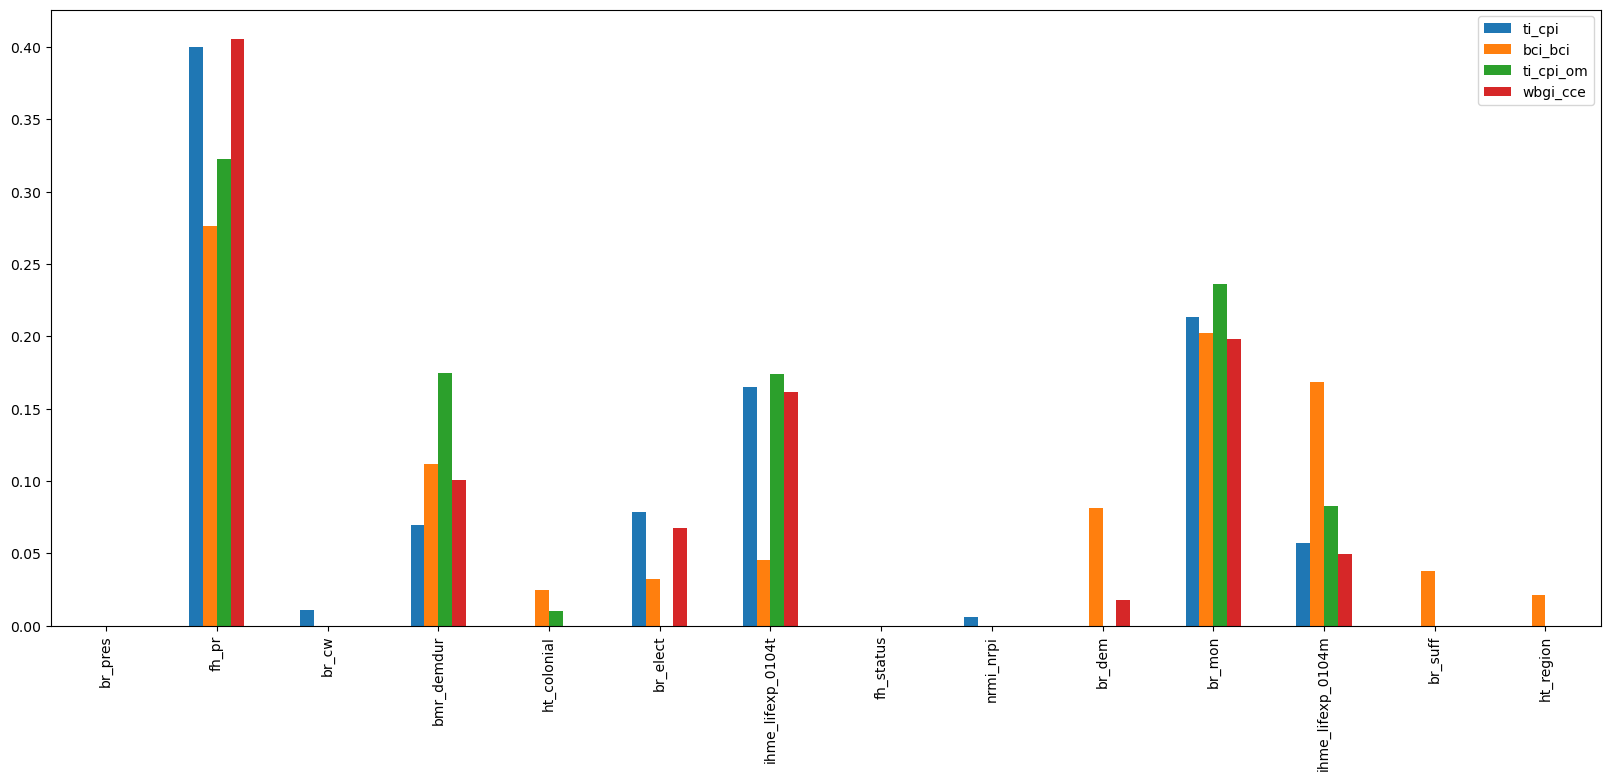

In [258]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

/home/david/miniconda3/envs/dopp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.3594263413106, tolerance: 52.50133005350952
  model = cd_fast.enet_coordinate_descent_gram(
/home/david/miniconda3/envs/dopp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 933.6126097280066, tolerance: 52.50133005350952
  model = cd_fast.enet_coordinate_descent_gram(
/home/david/miniconda3/envs/dopp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1284.3428106048377, tolerance: 52.50133005350952
  model = cd_fast.enet_coordinate_descent_gram(
/home/david/miniconda3/envs/dopp/lib

scores


,r2,rmse
ti_cpi,0.615536,9.762118
bci_bci,0.332581,10.712858
ti_cpi_om,0.447598,1.290257
wbgi_cce,0.536932,0.571373


feature importance


,fh_pr,ihme_hle_0104t,ihme_lifexp_0104f,br_mon,br_suff,bmr_demdur,fh_ipolity2,br_elect,ht_colonial,ht_region,...,br_dem,fh_status,br_cw,ihme_hle_0104m,bmr_dem,ihme_lifexp_0104t,ihme_lifexp_0104m,br_pres,ihme_hle_0104f,nrmi_nrpi
ti_cpi,0.0,0.0,0.0,0.193952,0.069417,0.077452,0.0,0.009638,0.0,0.0,...,0.0,0.0,0.000132,0.0,0.0,0.0,0.202445,0.0,0.0,0.0
bci_bci,0.152208,0.0,0.0,0.071322,0.013682,0.028828,0.114597,0.020318,0.021133,0.013427,...,0.010149,0.091463,0.015754,0.0,0.009813,0.11676,0.020056,0.007358,0.061761,0.017696
ti_cpi_om,0.0,0.0,0.0,0.189521,0.0,0.142025,0.0,0.037529,0.021114,0.0,...,0.023041,0.0,0.0,0.0,0.0,0.0,0.205236,0.0,0.0,0.0
wbgi_cce,0.0,0.0,0.0,0.173311,0.028425,0.097921,0.0,0.056442,0.002667,0.0,...,0.0,0.0,0.005325,0.0,0.0,0.019926,0.177569,0.0,0.0,0.0



feature importance rank


,fh_pr,ihme_hle_0104t,ihme_lifexp_0104f,br_mon,br_suff,bmr_demdur,fh_ipolity2,br_elect,ht_colonial,ht_region,...,br_dem,fh_status,br_cw,ihme_hle_0104m,bmr_dem,ihme_lifexp_0104t,ihme_lifexp_0104m,br_pres,ihme_hle_0104f,nrmi_nrpi
ti_cpi,<NA>,<NA>,<NA>,3,5,4,<NA>,6,<NA>,<NA>,...,<NA>,<NA>,7,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>
bci_bci,2,<NA>,<NA>,6,15,8,4,11,10,16,...,17,5,14,<NA>,18,3,12,19,7,13
ti_cpi_om,<NA>,<NA>,<NA>,3,<NA>,4,<NA>,5,7,<NA>,...,6,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>
wbgi_cce,<NA>,<NA>,<NA>,3,6,4,<NA>,5,9,<NA>,...,<NA>,<NA>,8,<NA>,<NA>,7,2,<NA>,<NA>,<NA>


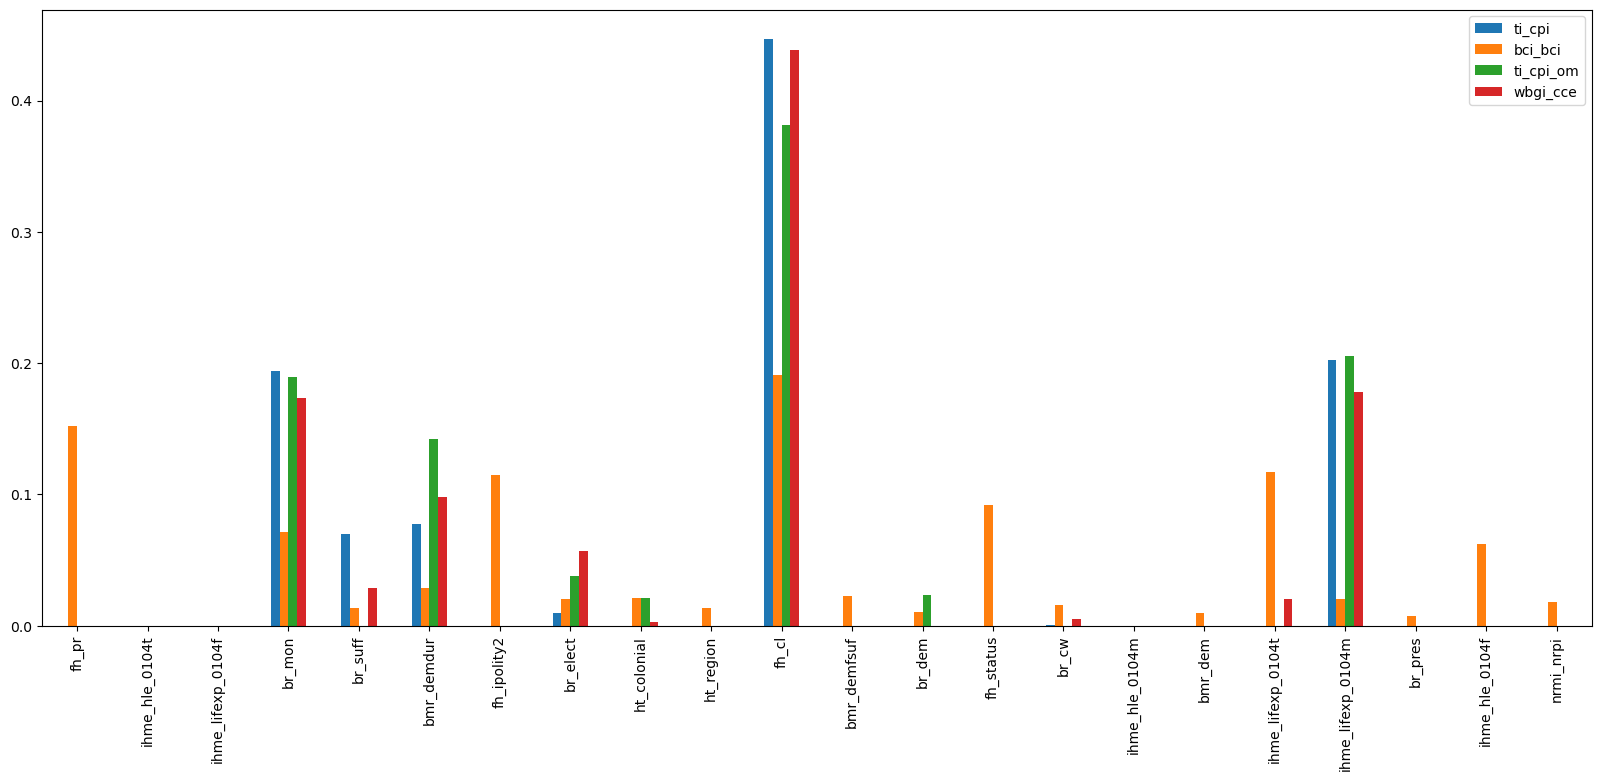

In [259]:
lasso_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.53651,10.718554
bci_bci,0.281457,11.115581
ti_cpi_om,0.42563,1.315664
wbgi_cce,0.504695,0.590927


feature importance


,br_pres,fh_pr,bmr_demdur,ht_colonial,br_elect,br_mon,fh_status,br_dem,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,0.0,0.412521,0.06835,0.0,0.092486,0.211933,0.0,0.003806,0.166141,0.044764
bci_bci,0.0,0.292213,0.113369,0.014673,0.055409,0.226431,0.0,0.070623,0.02648,0.200803
ti_cpi_om,0.0,0.337667,0.145394,0.023497,0.01881,0.198968,0.0,0.064413,0.137236,0.074016
wbgi_cce,0.0,0.40756,0.095981,0.0,0.071614,0.189107,0.0,0.034391,0.161798,0.039548



feature importance rank


,br_pres,fh_pr,bmr_demdur,ht_colonial,br_elect,br_mon,fh_status,br_dem,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,<NA>,1,5,<NA>,4,2,<NA>,7,3,6
bci_bci,<NA>,1,4,8,6,2,<NA>,5,7,3
ti_cpi_om,<NA>,1,3,7,8,2,<NA>,6,4,5
wbgi_cce,<NA>,1,4,<NA>,5,2,<NA>,7,3,6


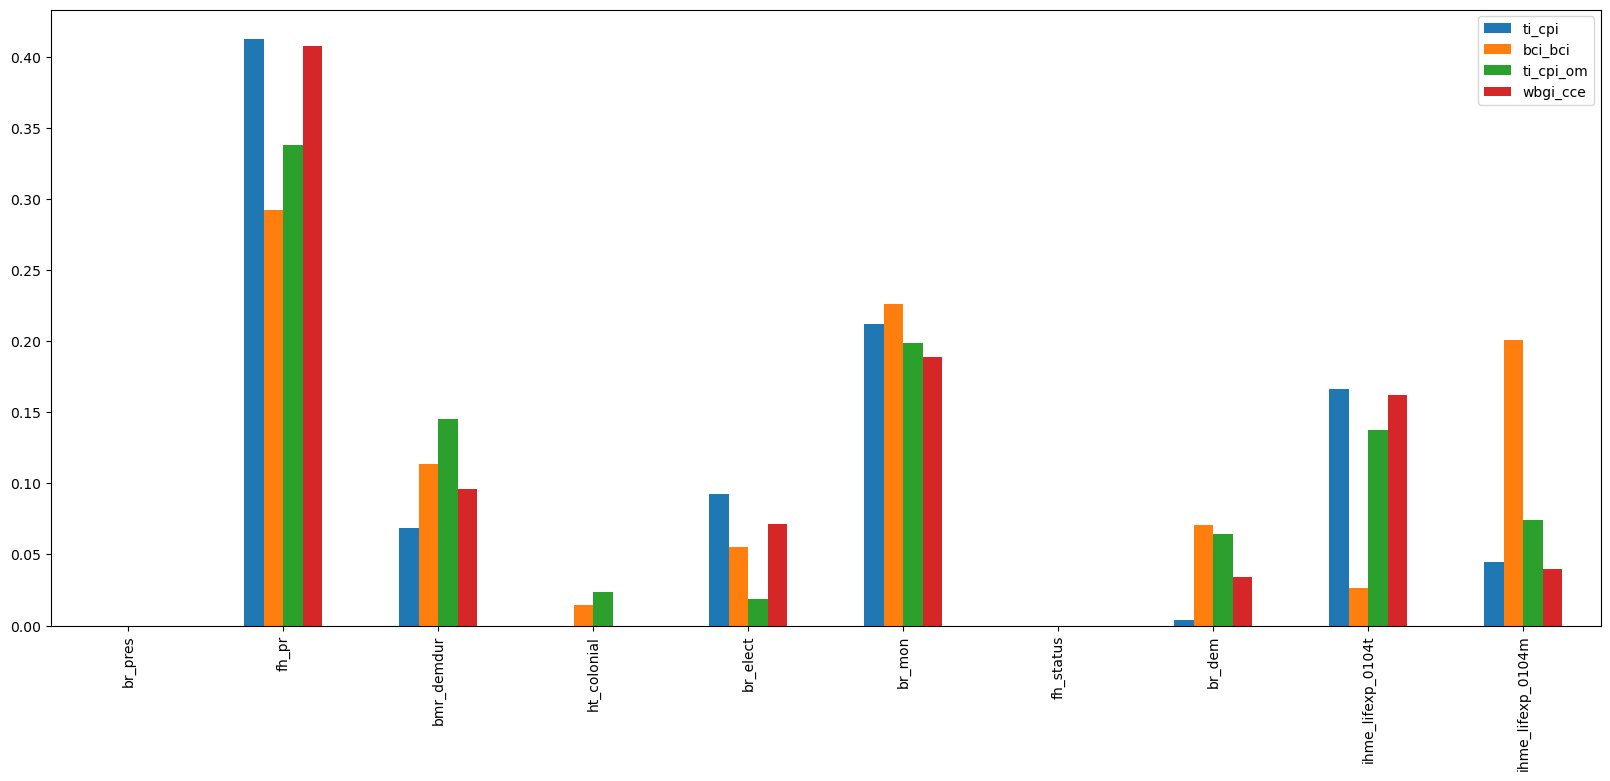

In [260]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [261]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



First we apply again the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.713831,8.422236
bci_bci,0.303505,10.943719
ti_cpi_om,0.341169,1.40908
wbgi_cce,0.538705,0.570278


feature importance


,br_pres,fh_pr,br_cw,bmr_demdur,ht_colonial,br_elect,ihme_lifexp_0104t,fh_status,nrmi_nrpi,br_dem,br_mon,ihme_lifexp_0104m,br_suff,ht_region
ti_cpi,0.003777,0.611178,0.007849,0.105993,0.023317,0.0088,0.073659,0.005381,0.035436,0.000883,0.050481,0.073245,NaN,NaN
bci_bci,0.015792,0.368904,NaN,0.152513,0.035384,0.021282,0.194591,0.008123,NaN,0.004022,0.09333,0.061762,0.00003,0.044267
ti_cpi_om,0.010407,0.467777,NaN,0.145375,0.006618,0.002785,0.205324,0.010772,0.031885,0.001343,0.051518,0.041853,NaN,0.024345
wbgi_cce,0.017979,0.619055,NaN,0.106277,0.017442,0.007648,0.063728,0.008964,0.03854,0.00143,0.043311,0.050294,NaN,0.025332



feature importance rank


,br_pres,fh_pr,br_cw,bmr_demdur,ht_colonial,br_elect,ihme_lifexp_0104t,fh_status,nrmi_nrpi,br_dem,br_mon,ihme_lifexp_0104m,br_suff,ht_region
ti_cpi,11,1,9,2,7,8,3,10,6,12,5,4,<NA>,<NA>
bci_bci,9,1,<NA>,3,7,8,2,10,<NA>,11,4,5,12,6
ti_cpi_om,9,1,<NA>,3,10,11,2,8,6,12,4,5,<NA>,7
wbgi_cce,8,1,<NA>,2,9,11,3,10,6,12,5,4,<NA>,7


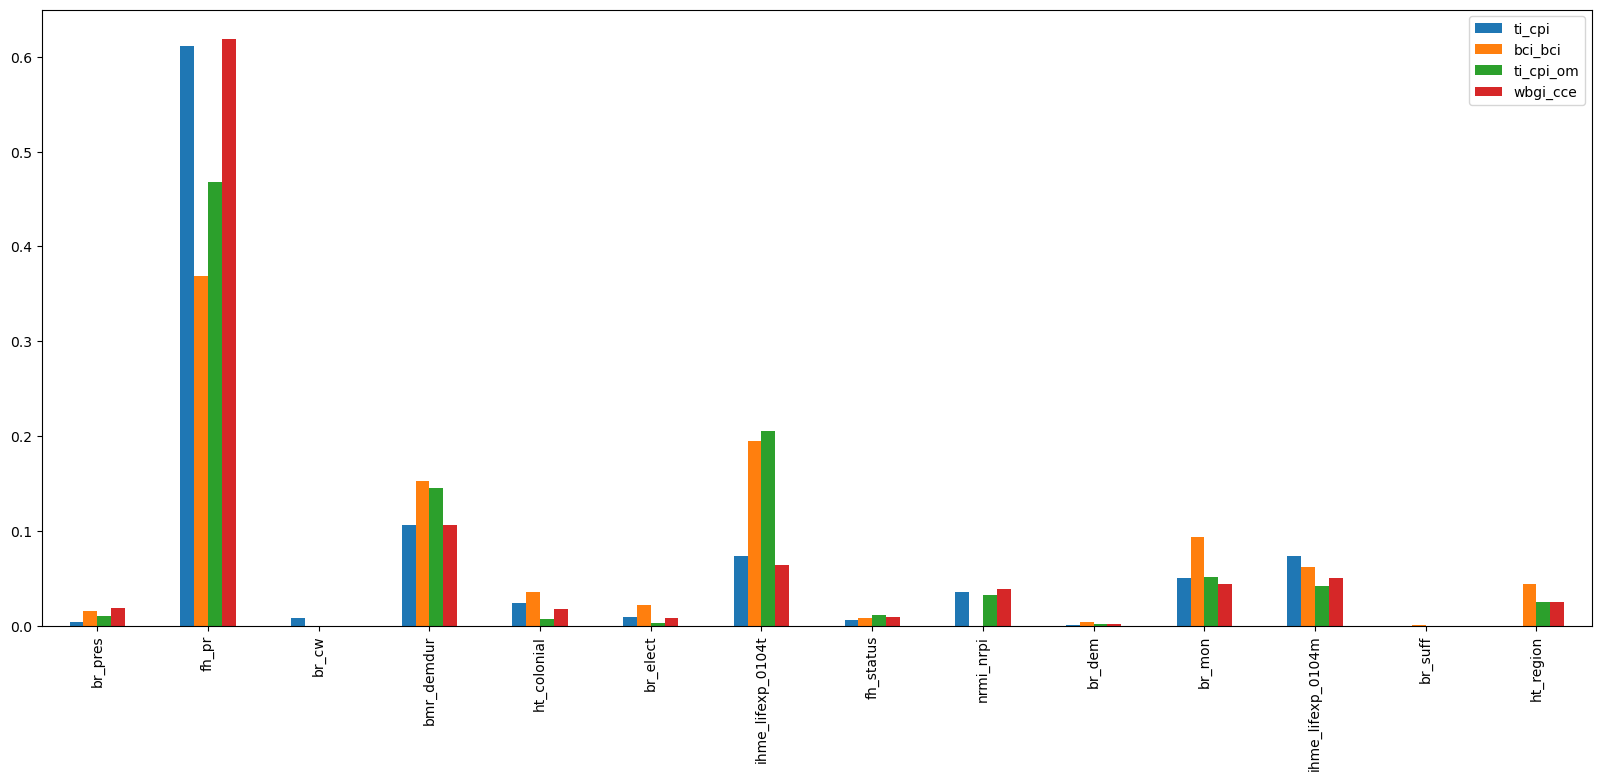

In [262]:
rf_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.712594,8.440413
bci_bci,0.305947,10.924518
ti_cpi_om,0.512019,1.212692
wbgi_cce,0.554828,0.560224


feature importance


,fh_pr,ihme_hle_0104t,ihme_lifexp_0104f,br_mon,br_suff,bmr_demdur,fh_ipolity2,br_elect,ht_colonial,ht_region,...,br_dem,fh_status,br_cw,ihme_hle_0104m,bmr_dem,ihme_lifexp_0104t,ihme_lifexp_0104m,br_pres,ihme_hle_0104f,nrmi_nrpi
ti_cpi,0.17114,0.031573,0.016247,0.033347,0.002046,0.069519,0.102518,0.004945,0.013825,0.005075,...,0.000739,0.000654,0.007184,0.019847,0.000368,0.047416,0.045165,0.005406,0.02852,0.018766
bci_bci,0.010239,0.042445,0.019006,0.075297,0.000084,0.110549,0.449457,0.011147,0.028761,0.021414,...,0.001102,0.001733,0.00585,0.039572,0.000963,0.047116,0.026058,0.020809,0.025276,0.039979
ti_cpi_om,0.013693,0.048485,0.01887,0.040159,0.001117,0.112244,0.550673,0.001433,0.004083,0.01162,...,0.000396,0.006271,0.004002,0.027971,0.002064,0.063092,0.02587,0.007665,0.022542,0.016076
wbgi_cce,0.24682,0.024477,0.015478,0.036302,0.002122,0.085785,0.380669,0.004526,0.012686,0.010997,...,0.000983,0.001246,0.006266,0.021599,0.001438,0.026758,0.028166,0.017502,0.025601,0.025184



feature importance rank


,fh_pr,ihme_hle_0104t,ihme_lifexp_0104f,br_mon,br_suff,bmr_demdur,fh_ipolity2,br_elect,ht_colonial,ht_region,...,br_dem,fh_status,br_cw,ihme_hle_0104m,bmr_dem,ihme_lifexp_0104t,ihme_lifexp_0104m,br_pres,ihme_hle_0104f,nrmi_nrpi
ti_cpi,2,8,12,7,18,4,3,17,13,16,...,19,20,14,10,21,5,6,15,9,11
bci_bci,16,5,14,3,22,2,1,15,8,12,...,20,18,17,7,21,4,9,13,10,6
ti_cpi_om,12,4,10,5,21,2,1,20,16,13,...,22,15,17,6,19,3,7,14,8,11
wbgi_cce,2,9,13,4,18,3,1,17,14,15,...,22,20,16,11,19,6,5,12,7,8


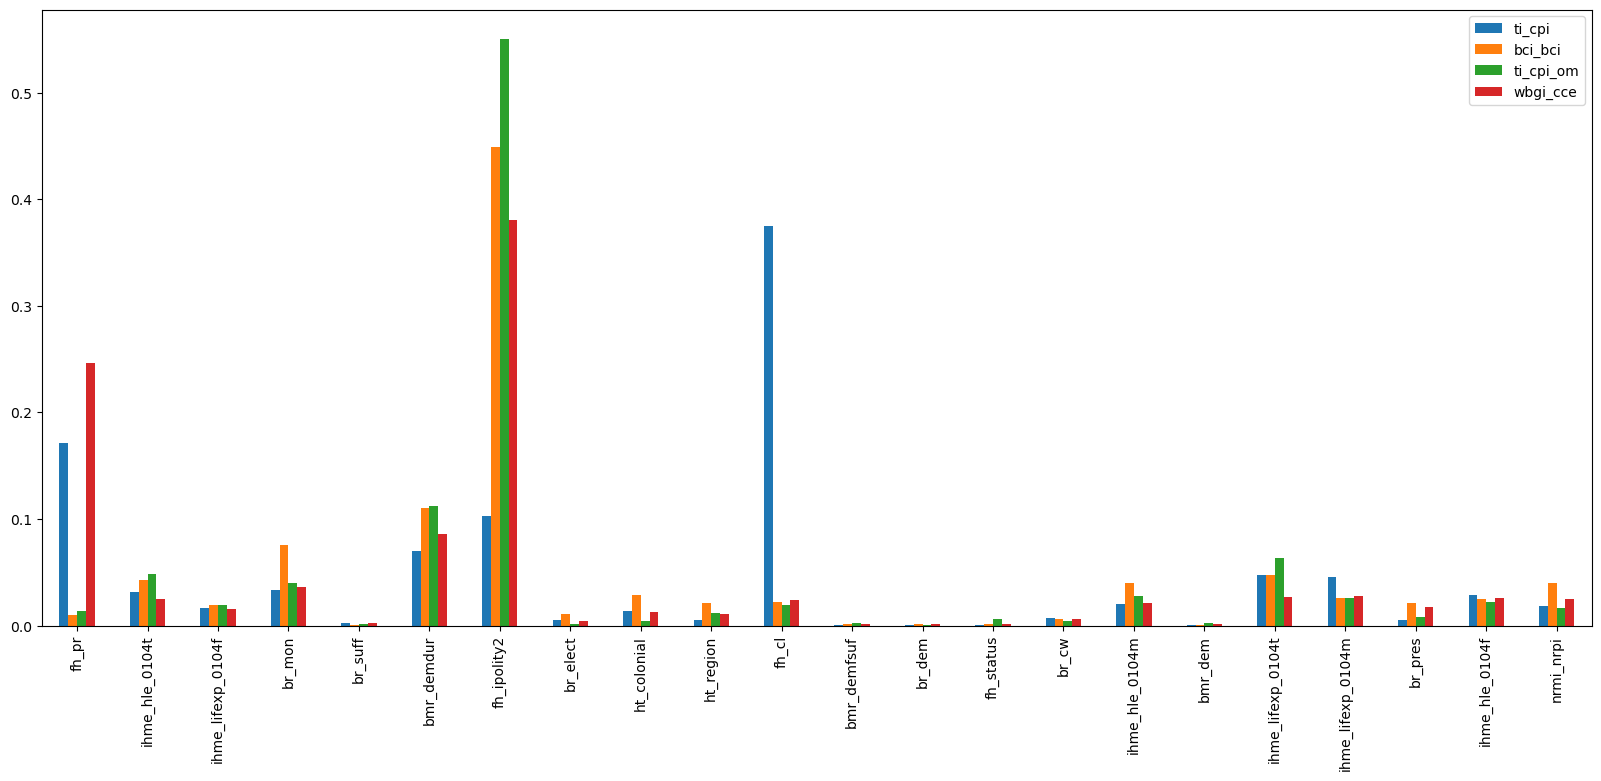

In [263]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.667813,9.074176
bci_bci,0.353356,10.544806
ti_cpi_om,0.409588,1.333909
wbgi_cce,0.589351,0.538063


feature importance


,br_pres,fh_pr,bmr_demdur,ht_colonial,br_elect,br_mon,fh_status,br_dem,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,0.006275,0.615727,0.116103,0.029033,0.011102,0.050707,0.007357,0.001331,0.082676,0.079689
bci_bci,0.017469,0.370884,0.159983,0.045066,0.022755,0.096146,0.008713,0.004144,0.201631,0.073209
ti_cpi_om,0.013339,0.474928,0.156546,0.009955,0.004642,0.05382,0.015514,0.001186,0.216185,0.053885
wbgi_cce,0.020597,0.622459,0.118611,0.027257,0.00946,0.046901,0.011363,0.00285,0.078341,0.062161



feature importance rank


,br_pres,fh_pr,bmr_demdur,ht_colonial,br_elect,br_mon,fh_status,br_dem,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,9,1,2,6,7,5,8,10,3,4
bci_bci,8,1,3,6,7,4,9,10,2,5
ti_cpi_om,7,1,3,8,9,5,6,10,2,4
wbgi_cce,7,1,2,6,9,5,8,10,3,4


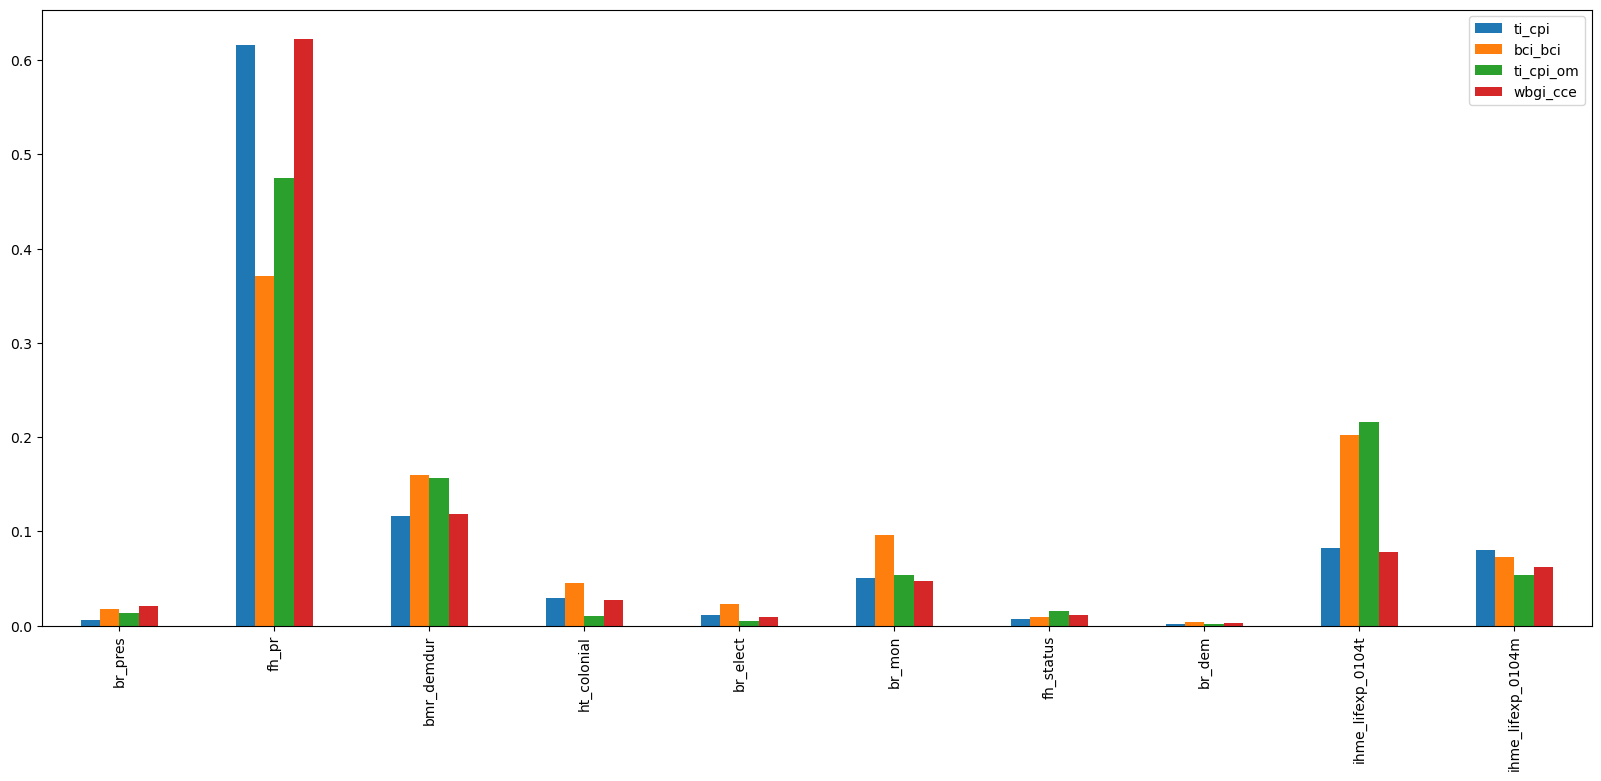

In [264]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [265]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

In [266]:
rf_gridsearch_info_script(selected_features_dict)

KeyboardInterrupt: 

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.